# Clustering Analysis - 'bustabit'

https://bustabit.com/

https://www.kaggle.com/datasets/kingabzpro/gambling-behavior-bustabit

In [173]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import math

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

## Data inspection

In [47]:
df = pd.read_csv('bustabit.csv', parse_dates=["PlayDate"])
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Id         50000 non-null  int64              
 1   GameID     50000 non-null  int64              
 2   Username   50000 non-null  object             
 3   Bet        50000 non-null  int64              
 4   CashedOut  28734 non-null  float64            
 5   Bonus      28734 non-null  float64            
 6   Profit     28734 non-null  float64            
 7   BustedAt   50000 non-null  float64            
 8   PlayDate   50000 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(4), int64(3), object(1)
memory usage: 3.4+ MB


,Id,GameID,Username,Bet,CashedOut,Bonus,Profit,BustedAt,PlayDate
0,14196549,3366002,papai,5,1.20,0.0,1.00,8.24,2016-11-20 19:44:19+00:00
1,10676217,3343882,znay22,3,NaN,NaN,NaN,1.40,2016-11-14 14:21:50+00:00
2,15577107,3374646,rrrrrrrr,4,1.33,3.0,1.44,3.15,2016-11-23 06:39:15+00:00
3,25732127,3429241,sanya1206,10,NaN,NaN,NaN,1.63,2016-12-08 18:13:55+00:00
4,17995432,3389174,ADM,50,1.50,1.4,25.70,2.29,2016-11-27 08:14:48+00:00
...,...,...,...,...,...,...,...,...,...
49995,21345100,3406167,ElenaV,4,NaN,NaN,NaN,4.80,2016-12-02 05:00:57+00:00
49996,1461408,3302415,Sandboxx,3000,1.04,0.0,120.00,5.03,2016-11-02 19:01:58+00:00
49997,19704592,3398419,Ferreck,1,NaN,NaN,NaN,1.06,2016-11-29 23:48:11+00:00
49998,20075463,3400278,ugneri,68,1.33,0.0,22.44,19.00,2016-11-30 12:29:56+00:00


In [85]:
print(f"First date: {df.PlayDate.min()}")
print(f"Last date: {df.PlayDate.max()}")

First date: 2016-10-31 15:38:43+00:00
Last date: 2016-12-10 20:09:12+00:00


In [48]:
df.Username.value_counts()

Username
megainvest       291
Babuan12345      272
xrnath           236
JohnL            234
Kirr923          216
                ... 
mavneee            1
Scorpius           1
FknJw              1
adswebtune         1
bitcoinbandit      1
Name: count, Length: 4149, dtype: int64

In [49]:
df.nunique()

Id           50000
GameID       42152
Username      4149
Bet           2758
CashedOut      478
Bonus          722
Profit        9057
BustedAt      3472
PlayDate     42152
dtype: int64

## Creating features

In [50]:
df = df.sort_values(["Username", "PlayDate"])

# Date column
df["Date"] = df["PlayDate"].dt.date
# Time column
df["Time"] = df["PlayDate"].dt.time
df["Time_s"] = df["Time"].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
# Win/Bust boolean
df["Win"] = df["CashedOut"].notna()
# Profit or loss of stake
df["PnL"] = df["Profit"].fillna(-df["Bet"])
# Bust multiplier only for games lost
df["BustMult"] = np.where(df["Win"], np.nan, df["BustedAt"])
# Numbering games per day, in order of play
df["Date_Game_Num"] = df.sort_values(["Username", "PlayDate"]).groupby(["Username", "Date"]).cumcount() + 1

In [51]:
# Game number of first bust, per date
first_busts = df.loc[~df["Win"]].groupby(["Username", "Date"])[["Date_Game_Num"]].first()
df = df.merge(first_busts, on=['Username', 'Date'], how="left", suffixes=('','_first_bust'))

# Games after first bust, per date
df_after_first_bust = df.loc[df['Date_Game_Num'] > df['Date_Game_Num_first_bust']]
games_after_first_bust = df_after_first_bust.groupby(['Username', 'Date']).size().reset_index(name='Games_after_first_bust')

df = df.merge(games_after_first_bust, on=['Username', 'Date'], how="left")
df["Games_after_first_bust"] = df["Games_after_first_bust"].fillna(0)

print(len(df))
df.head(10)

50000


,Id,GameID,Username,Bet,CashedOut,Bonus,Profit,BustedAt,PlayDate,Date,Time,Time_s,Win,PnL,BustMult,Date_Game_Num,Date_Game_Num_first_bust,Games_after_first_bust
0,1764275,3304047,----------------,11,1.01,2.27,0.36,1.03,2016-11-03 06:14:27+00:00,2016-11-03,06:14:27,22467,True,0.36,NaN,1,3.0,0.0
1,2027336,3305330,----------------,12,1.01,1.83,0.34,3.25,2016-11-03 15:05:40+00:00,2016-11-03,15:05:40,54340,True,0.34,NaN,2,3.0,0.0
2,2194462,3306129,----------------,8,NaN,NaN,NaN,1.09,2016-11-03 20:26:24+00:00,2016-11-03,20:26:24,73584,False,-8.00,1.09,3,3.0,0.0
3,911557,3299445,--dilib--,349,1.60,1.87,215.91,4.37,2016-11-01 22:57:26+00:00,2016-11-01,22:57:26,82646,True,215.91,NaN,1,NaN,0.0
4,961649,3299733,--dilib--,98,2.54,4.63,155.46,11.95,2016-11-02 00:56:16+00:00,2016-11-02,00:56:16,3376,True,155.46,NaN,1,2.0,2.0
5,1121676,3300711,--dilib--,311,NaN,NaN,NaN,0.00,2016-11-02 07:30:53+00:00,2016-11-02,07:30:53,27053,False,-311.00,0.00,2,2.0,2.0
6,1228506,3301236,--dilib--,167,NaN,NaN,NaN,1.31,2016-11-02 11:03:15+00:00,2016-11-02,11:03:15,39795,False,-167.00,1.31,3,2.0,2.0
7,1419860,3302204,--dilib--,757,NaN,NaN,NaN,1.86,2016-11-02 17:31:02+00:00,2016-11-02,17:31:02,63062,False,-757.00,1.86,4,2.0,2.0
8,1831433,3304389,--dilib--,2,NaN,NaN,NaN,1.03,2016-11-03 08:39:20+00:00,2016-11-03,08:39:20,31160,False,-2.00,1.03,1,1.0,2.0
9,1836022,3304412,--dilib--,1,NaN,NaN,NaN,2.33,2016-11-03 08:48:12+00:00,2016-11-03,08:48:12,31692,False,-1.00,2.33,2,1.0,2.0


Initial thoughts - group by player

- Number the game per session (day?)

- how to treat players with low numbers of games?
    - total metrics vs avg metrics?

- Metrics:
    - totals:
        - total games (count 'GameID')
        - total busts (count 'Win'==False)
        - total sessions (count unique 'Date')
        - total amount wagered (sum 'Bet)
        - total PnL (sum 'PnL')
        - total return?
    - averages:
        - avg games per session (nunique Date / count Date?)
        - avg busts per session (count 'Win'==False / count Date)
        - avg bust multiplier (mean BustedAt where 'Win'==False)
        - avg cashout multiplier (mean CashedOut, excl NaN)
        - avg number of games before first bust (luck)
        - avg number of games after first bust (determination...)
        - avg number of players in the game (potentially flawed given small data set)
        - average time of play
    - min/max (all avg cols?):
        - games per date (min/max of Date_Game_Num)
        - CashedOut multiplier (min/max of CashedOut, excl NaN)
        - busts per date
        - 

## GroupBy `Username`

In [52]:
# 'Total' metrics
total_agg_map = {"GameID":"count", "Date":"nunique", "Bet":"sum", "Profit":"sum", "PnL":"sum", "Win":"sum"}

total_col_map = {"GameID":"Num_games", "Date":"Num_sessions", "Bet":"Total_amt_bet",
           "Profit":"Gross_profit", "PnL":"Net_profit", "Win":"Num_wins"}

total_cols = list(total_agg_map.keys())

totals_df = df.groupby("Username")[total_cols].agg(total_agg_map).rename(columns=total_col_map)
totals_df["Num_busts"] = totals_df["Num_games"] - totals_df["Num_wins"]
totals_df["Win_rate"] = totals_df["Num_wins"] / totals_df["Num_games"]
# totals_df

In [53]:
# 'Average' metrics
ud_agg_map = {"GameID":"count", "Win":"sum" , "Date_Game_Num_first_bust":"first",
              "Games_after_first_bust":"first"}

ud_col_map = {"GameID":"Games_per_session", "Win":"Wins_per_session", "Date_Game_Num_first_bust":"First_bust"}

ud_cols = list(ud_agg_map.keys())

# Creating 'per session' underlying data (to then avg)
user_date_df = df.groupby(["Username", "Date"])[ud_cols].agg(ud_agg_map).rename(columns=ud_col_map)
user_date_df["Busts_per_session"] = user_date_df["Games_per_session"] - user_date_df["Wins_per_session"]
user_date_df = user_date_df.reset_index()

# Average per session df
avgs_df = user_date_df.drop(columns="Date").groupby("Username").mean()

# Overall averages df
avg_col_map = {"Bet":"Avg_bet", "CashedOut":"Avg_cashout_mult", "BustMult":"Avg_bust_mult",
               "Profit":"Avg_profit", "PnL":"Avg_PnL", "Time_s":"Avg_time"}
avg_cols = list(avg_col_map.keys())
avgs_df_2 = df.groupby("Username")[avg_cols].mean().rename(columns=avg_col_map)

# Merging to create Averages df
avgs_df = avgs_df.merge(avgs_df_2, left_index=True, right_index=True)
# avgs_df

In [54]:
# 'Min/Max' metrics

# per session metrics
minmax_date_cols = ["Games_per_session", "Wins_per_session", "Busts_per_session"]
minmax_df = user_date_df.groupby("Username")[minmax_date_cols].agg(["min", "max"])

# Overall metrics
minmax_cols = ["CashedOut", "BustMult", "Bet", "Profit", "PnL"]
minmax_df_2 = df.groupby("Username")[minmax_cols].agg(["min", "max"])

# Merge together
minmax_df = minmax_df.merge(minmax_df_2, left_index=True, right_index=True)
minmax_df.columns = [i + '_' + j for i, j in minmax_df.columns]
# minmax_df

In [55]:
# Merge all together
user_df = totals_df.merge(avgs_df, left_index=True, right_index=True).reset_index()
# user_df = user_df.merge(minmax_df, left_index=True, right_index=True)

In [56]:
print(user_df.shape)
user_df.head()

(4149, 20)


,Username,Num_games,Num_sessions,Total_amt_bet,Gross_profit,Net_profit,Num_wins,Num_busts,Win_rate,Games_per_session,Wins_per_session,First_bust,Games_after_first_bust,Busts_per_session,Avg_bet,Avg_cashout_mult,Avg_bust_mult,Avg_profit,Avg_PnL,Avg_time
0,----------------,3,1,31,0.70,-7.30,2,1,0.666667,3.000000,2.000000,3.000000,0.000000,1.000000,10.333333,1.010000,1.090000,0.350000,-2.433333,50130.333333
1,--dilib--,8,3,1686,371.37,-867.63,2,6,0.250000,2.666667,0.666667,1.500000,1.333333,2.000000,210.750000,2.070000,1.306667,185.685000,-108.453750,42767.125000
2,-31337-,4,1,130,21.50,-33.50,3,1,0.750000,4.000000,3.000000,4.000000,0.000000,1.000000,32.500000,1.266667,1.070000,7.166667,-8.375000,65967.250000
3,-Nothing-,65,22,20987,3794.31,-3120.69,42,23,0.646154,2.954545,1.909091,1.857143,1.090909,1.045455,322.876923,1.422857,1.396522,90.340714,-48.010615,44791.461538
4,-Tachyon,5,1,5124,629.68,-1494.32,4,1,0.800000,5.000000,4.000000,5.000000,0.000000,1.000000,1024.800000,1.222500,1.330000,157.420000,-298.864000,54442.200000


In [57]:
never_lost = df["Username"].nunique() - df.loc[~df["Win"], "Username"].nunique()
never_won = df["Username"].nunique() - df.loc[df["Win"], "Username"].nunique()

print(f'Out of {df["Username"].nunique()} players, {never_lost} never lost and {never_won} never won.')

Out of 4149 players, 1231 never lost and 745 never won.


## PCA

In [58]:
X = user_df.select_dtypes("number").copy()

# Fillna as 0
X = X.fillna(0)

# Drop unncessary columns
drop_cols = ["Num_wins", "Num_busts", "Busts_per_session"]#, "Busts_per_session_min", "Busts_per_session_max"]
X = X.drop(columns=drop_cols)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Num_games               4149 non-null   int64  
 1   Num_sessions            4149 non-null   int64  
 2   Total_amt_bet           4149 non-null   int64  
 3   Gross_profit            4149 non-null   float64
 4   Net_profit              4149 non-null   float64
 5   Win_rate                4149 non-null   float64
 6   Games_per_session       4149 non-null   float64
 7   Wins_per_session        4149 non-null   float64
 8   First_bust              4149 non-null   float64
 9   Games_after_first_bust  4149 non-null   float64
 10  Avg_bet                 4149 non-null   float64
 11  Avg_cashout_mult        4149 non-null   float64
 12  Avg_bust_mult           4149 non-null   float64
 13  Avg_profit              4149 non-null   float64
 14  Avg_PnL                 4149 non-null   

In [59]:
scaler = StandardScaler()
decomp = PCA()
pipe = make_pipeline(scaler, decomp)

pipe.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

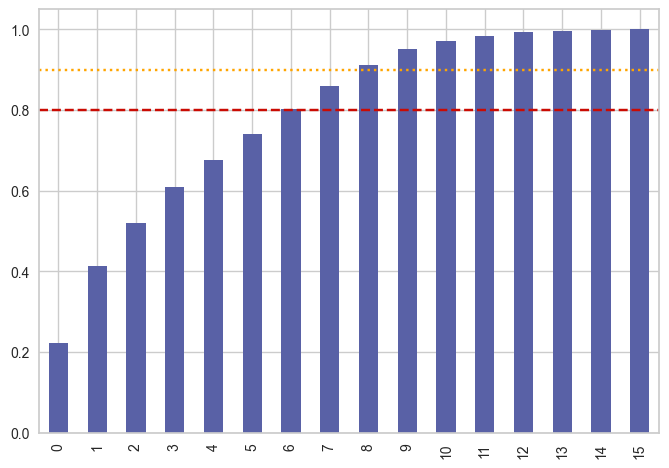

In [60]:
pd.Series(pipe['pca'].explained_variance_ratio_).cumsum().plot(kind="bar")
plt.axhline(y=0.8, color='r', linestyle="--")
plt.axhline(y=0.9, color='orange', linestyle=":")

In [61]:
scaler = StandardScaler()
decomp = PCA(n_components=8)
pipe = make_pipeline(scaler, decomp)

pipe.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=8))])

In [62]:
loadings = pipe['pca'].components_

# Iterate over PCs to get top contributing features to each PC 
for i, component in enumerate(loadings):
    # Get feature contribution for each component
    feature_contributions = np.abs(component)
    # Sort descendingly and get corresponding column index
    top_contributing_features = np.argsort(feature_contributions)[::-1]
    # Print results
    print(f"Principal Component {i+1}")
    for feature_idx in top_contributing_features:
#         print(f"Feature {feature_idx}: {feature_contributions[feature_idx]}")
        print(f"{X.columns[feature_idx]}: {feature_contributions[feature_idx]}")
        
    print()

Principal Component 1
Games_per_session: 0.4629701443187542
Num_games: 0.44123444557555125
Num_sessions: 0.39618220391667003
Games_after_first_bust: 0.38110292909893034
Wins_per_session: 0.33106767295423734
First_bust: 0.32496256835894516
Gross_profit: 0.14245060844708118
Total_amt_bet: 0.12994295062327976
Avg_cashout_mult: 0.12222267475807524
Net_profit: 0.09495360045612845
Avg_profit: 0.07445531930693512
Avg_PnL: 0.059407290312340516
Avg_bust_mult: 0.04991826487677591
Avg_bet: 0.02844993420135157
Avg_time: 0.007260916427762814
Win_rate: 0.00242178734752106

Principal Component 2
Gross_profit: 0.48474075524646265
Avg_profit: 0.4574934062379592
Net_profit: 0.405127993113375
Total_amt_bet: 0.3692792344686791
Avg_PnL: 0.32389907606527535
Avg_bet: 0.3057965242104962
Games_per_session: 0.12814034317657716
Games_after_first_bust: 0.10988348029218163
First_bust: 0.1030115690405273
Num_games: 0.08352918197536024
Wins_per_session: 0.06745530162054918
Num_sessions: 0.053254375722979086
Win_rate

<Axes: xlabel='0', ylabel='1'>

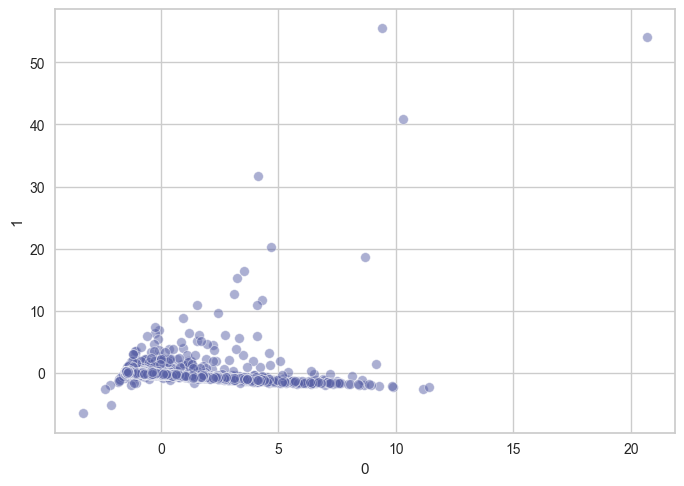

In [63]:
sns.scatterplot(data=pd.DataFrame(pipe[:2].transform(X)[:,[0,1]]), x=0, y=1, alpha=0.5)

## KMeans

### Elbow Curve

In [64]:
# No PCA
scaler = StandardScaler()
cluster = KElbowVisualizer(KMeans(n_init=10))
pipe = make_pipeline(scaler, cluster)

pipe.fit(X)


KeyboardInterrupt



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=8)),
                ('kelbowvisualizer',
                 KElbowVisualizer(ax=<Axes: >,
                                  estimator=KMeans(n_clusters=10, n_init=10)))])

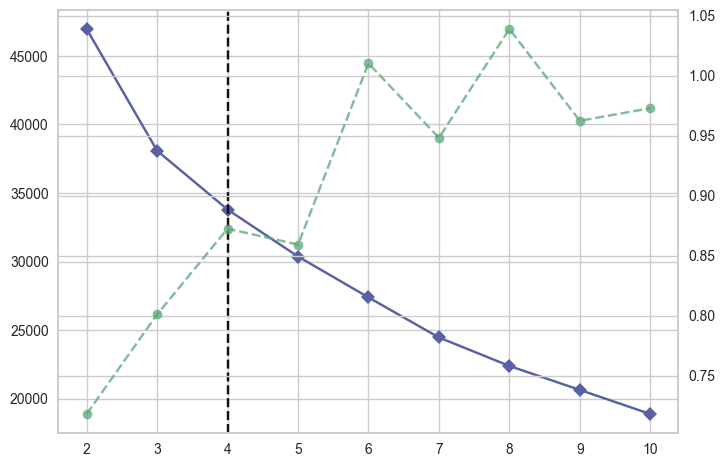

In [65]:
# With PCA
scaler = StandardScaler()
decomp = PCA(n_components=8)
cluster = KElbowVisualizer(KMeans(n_init=10))
pipe = make_pipeline(scaler, decomp, cluster)

pipe.fit(X)

### Finalise pipeline

In [129]:
# Perform PCA?
pca = False

# Set up pipeline
scaler = StandardScaler()
decomp = PCA(n_components=8)
# cluster = KMeans(n_init=10, n_clusters=4)
cluster = KMeans(n_init=10, n_clusters=4, random_state=5)

if pca:
    pipe = make_pipeline(scaler, decomp, cluster)
else:
    pipe = make_pipeline(scaler, cluster)

# Run pipeline
pipe.fit(X)

res_df = X.copy()

# If PCA, add PC values
if pca:
    pc_values = pipe[:2].transform(X)
    pc_labels = [f"PC{idx+1}" for idx, i in enumerate(pc_values.T)]
    res_df = res_df.join(pd.DataFrame(pc_values, columns=pc_labels))
else:
    pass

# Add Cluster labels
res_df["Cluster"] = pipe['kmeans'].labels_

res_df.shape

(4149, 17)

## Cluster analysis

In [130]:
shades = ["#5961A6", "#A65988", "#59A677", "#A69E59"]

sns.set_palette(shades)
sns.color_palette()

[(0.34901960784313724, 0.3803921568627451, 0.6509803921568628),
 (0.6509803921568628, 0.34901960784313724, 0.5333333333333333),
 (0.34901960784313724, 0.6509803921568628, 0.4666666666666667),
 (0.6509803921568628, 0.6196078431372549, 0.34901960784313724)]

In [159]:
cluster_name_map = {0:"Addicts", 
                    1:"Suckers", 
                    2:"One-shot Wonders", 
                    3:"High Rollers"}

res_df["Group"] = res_df["Cluster"].map(cluster_name_map)
res_df = res_df.sort_values("Cluster")

In [156]:
res_df.head()

,Num_games,Num_sessions,Total_amt_bet,Gross_profit,Net_profit,Win_rate,Games_per_session,Wins_per_session,First_bust,Games_after_first_bust,Avg_bet,Avg_cashout_mult,Avg_bust_mult,Avg_profit,Avg_PnL,Avg_time,Cluster,Group
0,3,1,31,0.70,-7.30,0.666667,3.000000,2.000000,3.000000,0.000000,10.333333,1.010000,1.090000,0.350000,-2.433333,50130.333333,1,Suckers
1,8,3,1686,371.37,-867.63,0.250000,2.666667,0.666667,1.500000,1.333333,210.750000,2.070000,1.306667,185.685000,-108.453750,42767.125000,1,Suckers
2,4,1,130,21.50,-33.50,0.750000,4.000000,3.000000,4.000000,0.000000,32.500000,1.266667,1.070000,7.166667,-8.375000,65967.250000,0,Addicts
3,65,22,20987,3794.31,-3120.69,0.646154,2.954545,1.909091,1.857143,1.090909,322.876923,1.422857,1.396522,90.340714,-48.010615,44791.461538,0,Addicts
4,5,1,5124,629.68,-1494.32,0.800000,5.000000,4.000000,5.000000,0.000000,1024.800000,1.222500,1.330000,157.420000,-298.864000,54442.200000,0,Addicts


#### Cluster proportions

In [160]:
for i in range(4):
    print(f'{cluster_name_map[i]}: {len(res_df.loc[res_df["Cluster"]==i, "Cluster"])} users.')

Addicts: 758 users.
Suckers: 2048 users.
One-shot Wonders: 1339 users.
High Rollers: 4 users.


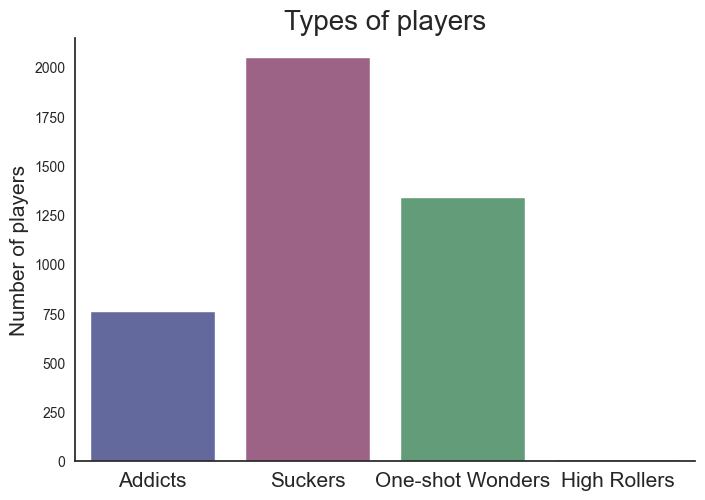

In [211]:
groups = plt.figure()
sns.set_style("white")
sns.countplot(data=res_df, x="Group", hue="Group", palette=shades)
sns.despine()
plt.xticks(fontsize=15)
plt.xlabel("")
plt.ylabel("Number of players", fontsize=15)
plt.title("Types of players", fontsize=20)
plt.show()

In [213]:
groups.savefig("Charts\\groups.png", transparent=True, bbox_inches="tight")

In [162]:
res_df.columns

Index(['Num_games', 'Num_sessions', 'Total_amt_bet', 'Gross_profit',
       'Net_profit', 'Win_rate', 'Games_per_session', 'Wins_per_session',
       'First_bust', 'Games_after_first_bust', 'Avg_bet', 'Avg_cashout_mult',
       'Avg_bust_mult', 'Avg_profit', 'Avg_PnL', 'Avg_time', 'Cluster',
       'Group'],
      dtype='object')

In [112]:
def seconds_to_time(seconds):
    return str(dt.timedelta(seconds=seconds))

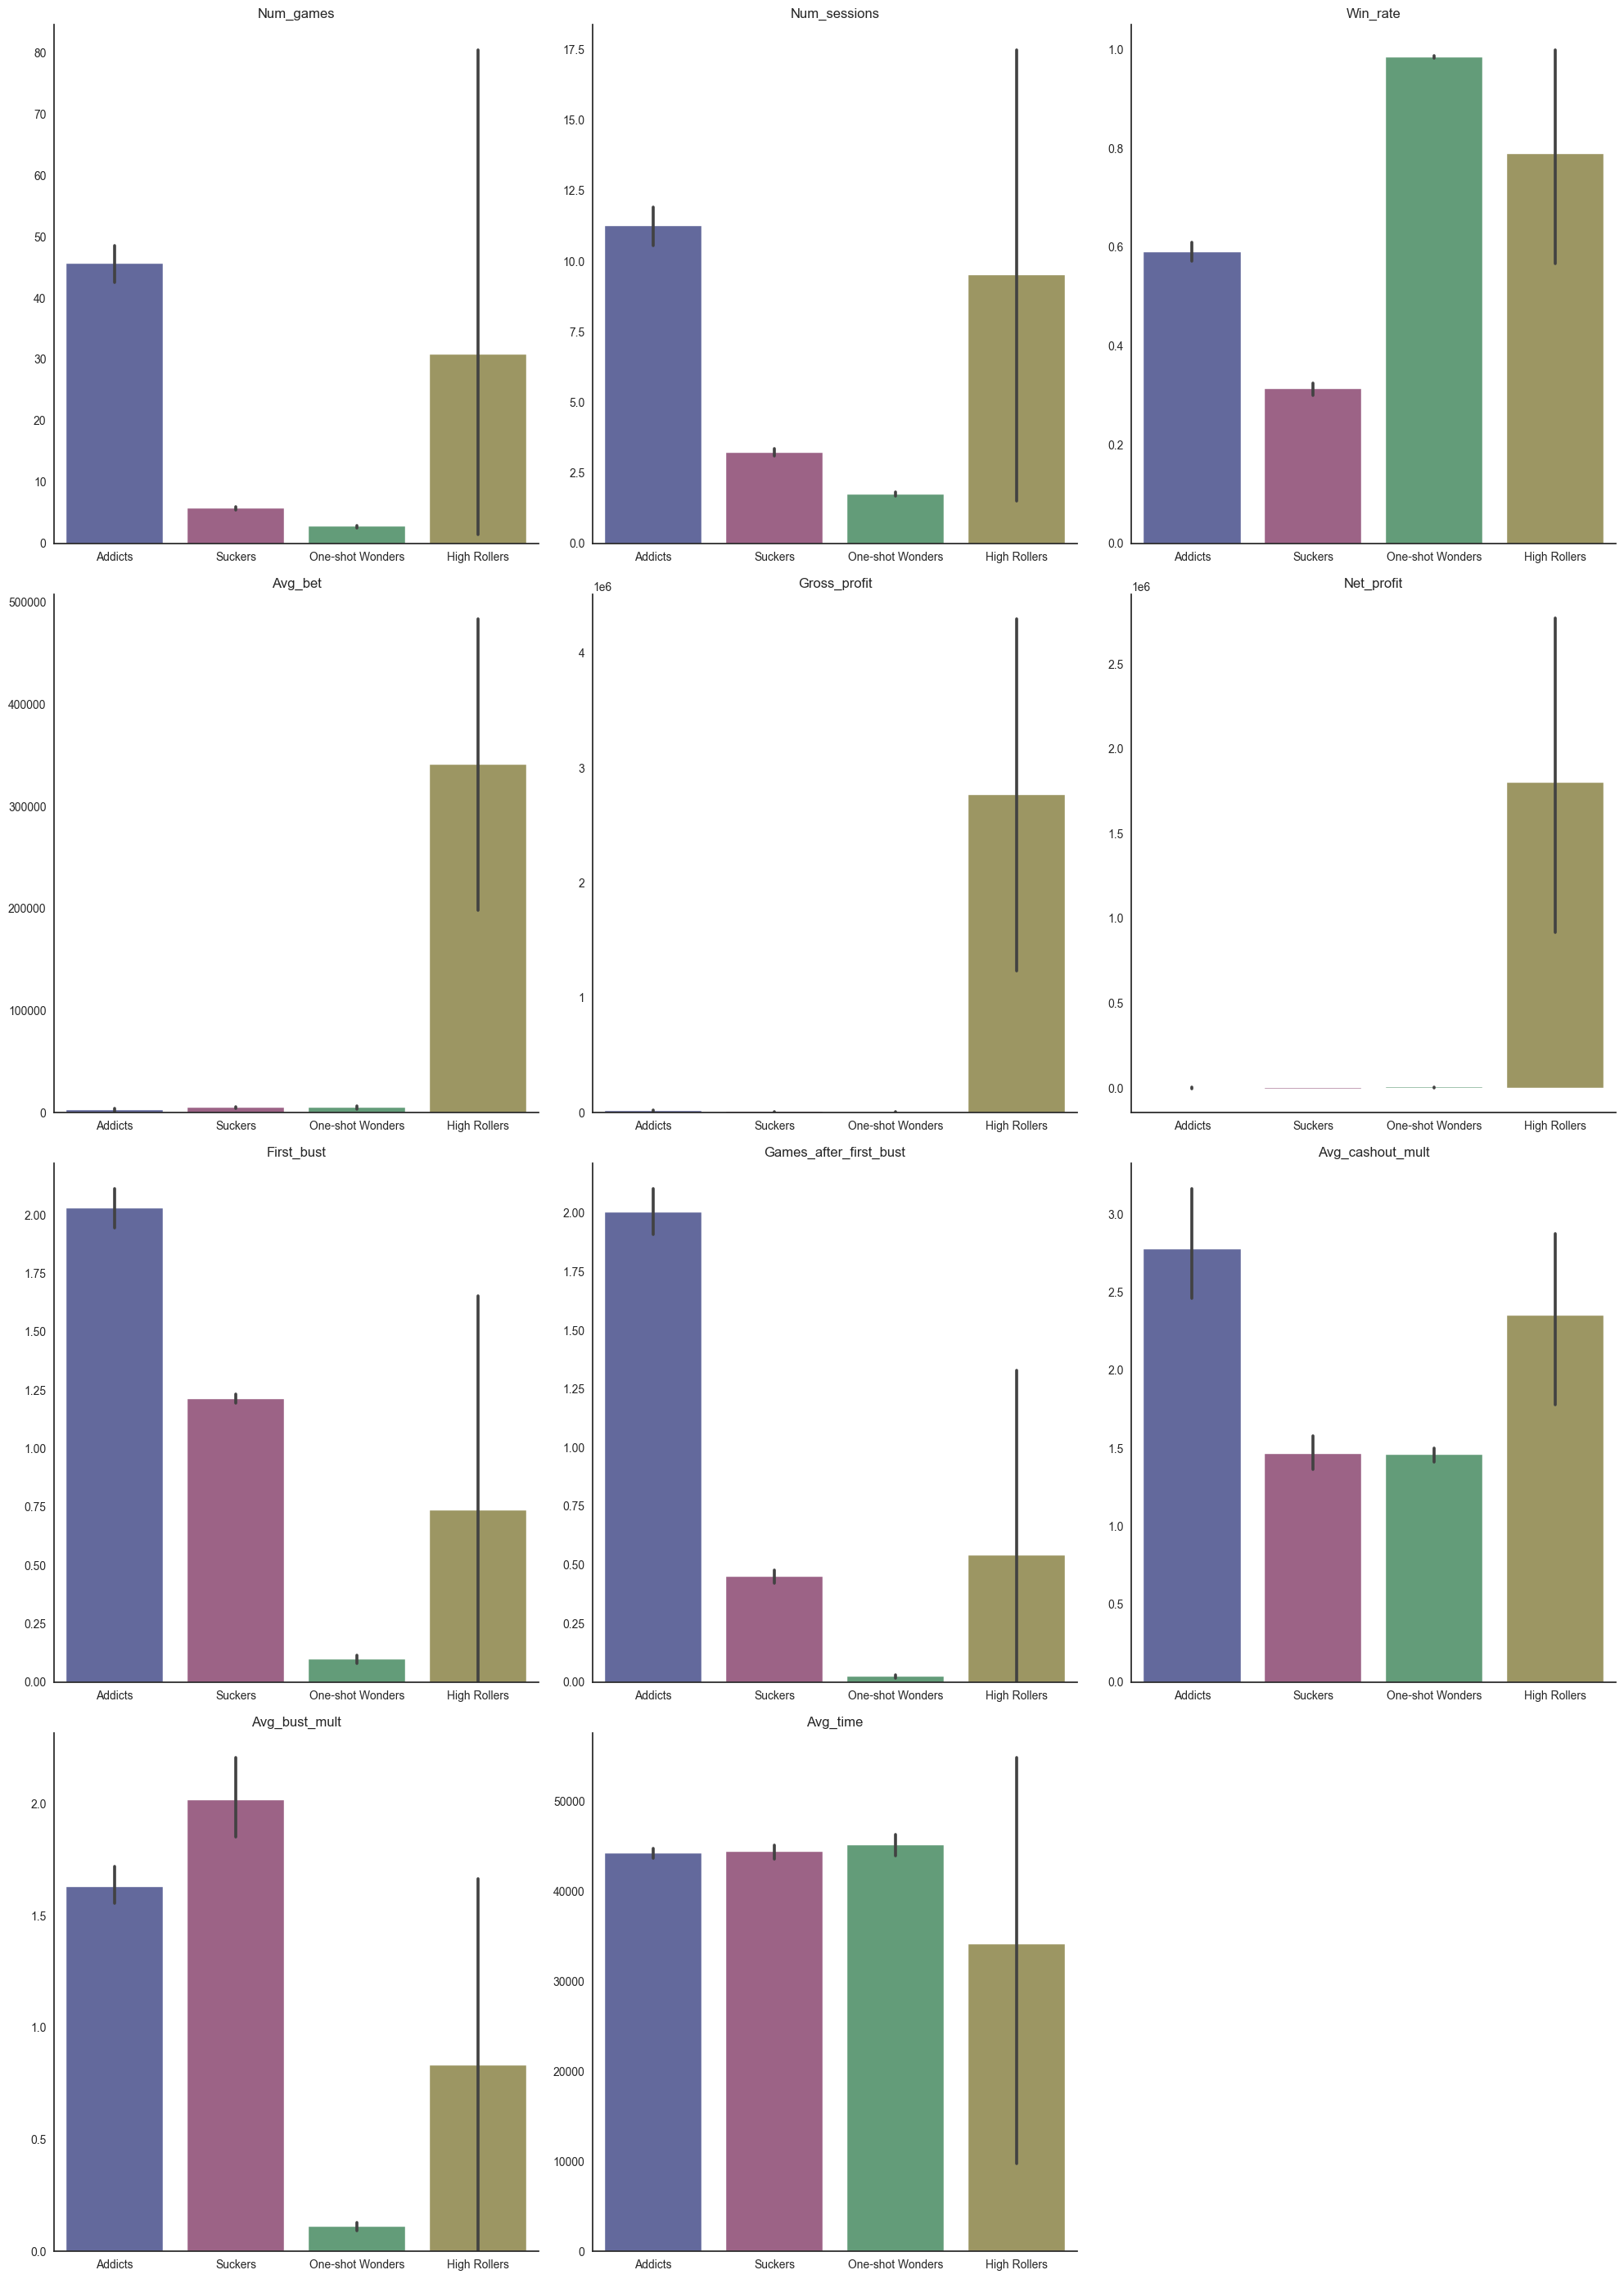

In [163]:
var_lst = '''
    Num_games
    Num_sessions
    Win_rate
    Avg_bet
    Gross_profit
    Net_profit
    First_bust
    Games_after_first_bust
    Avg_cashout_mult
    Avg_bust_mult
    Avg_time
'''.split()

fig_rows = math.ceil(len(var_lst)/3)

fig, axs = plt.subplots(fig_rows, 3, figsize=(20, 7*fig_rows))

for var, ax in zip(var_lst, axs.flat):
    g = sns.barplot(data=res_df, x="Group", y=var, ax=ax, hue="Group", palette=shades)
    # Formatting
    ax.set(xlabel='', ylabel='', title=var)
    sns.despine()    
    
# Remove spare plot
for i in axs.flat[::-1][:fig_rows*3 - len(var_lst)]:
    i.set_axis_off()
    
plt.tight_layout()
plt.show()

In [132]:
user_df["Cluster"] = pipe['kmeans'].labels_
user_df.loc[user_df["Cluster"]==3]

,Username,Num_games,Num_sessions,Total_amt_bet,Gross_profit,Net_profit,Num_wins,Num_busts,Win_rate,Games_per_session,...,First_bust,Games_after_first_bust,Busts_per_session,Avg_bet,Avg_cashout_mult,Avg_bust_mult,Avg_profit,Avg_PnL,Avg_time,Cluster
643,GPL89,2,2,975000,1875559.41,1875559.41,2,0,1.000000,1.000000,...,NaN,0.000000,0.000000,487500.000000,2.920000,NaN,937779.705000,937779.705000,63942.000000,3
2004,allg1124,101,22,16262350,4794154.34,3182621.34,74,27,0.732673,4.590909,...,1.833333,1.772727,1.227273,161013.366337,1.427297,1.636296,64785.869459,31511.102376,41102.801980,3
2667,goosin2000,19,13,4469000,3803213.87,1544213.87,8,11,0.421053,1.461538,...,1.111111,0.384615,0.846154,235210.526316,2.831250,1.690909,475401.733750,81274.414211,27628.210526,3
3584,sce919,1,1,480000,596856.84,596856.84,1,0,1.000000,1.000000,...,NaN,0.000000,0.000000,480000.000000,2.230000,NaN,596856.840000,596856.840000,3800.000000,3


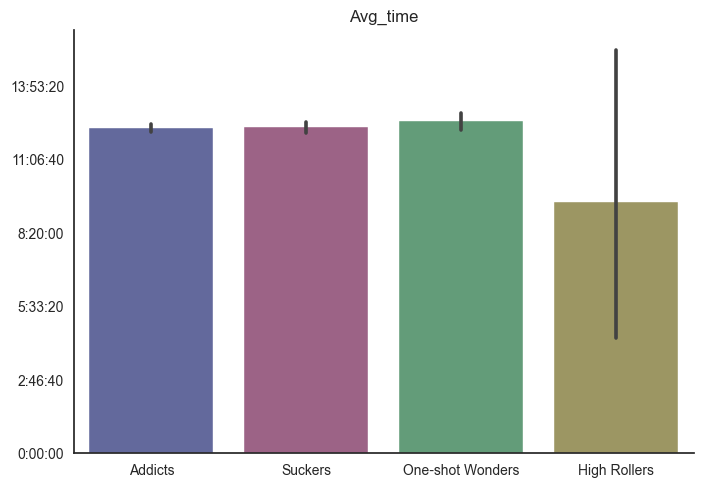

In [164]:
sns.barplot(data=res_df, x="Group", y="Avg_time", hue="Group", palette=shades)

formatter = FuncFormatter(lambda x, pos: seconds_to_time(int(x)))
plt.gca().yaxis.set_major_formatter(formatter)
sns.despine()

plt.xlabel('')
plt.ylabel('')
plt.title('Avg_time')
plt.show()

In [123]:
seconds_to_time(df.Time_s.mean())

'12:18:19.230980'

In [166]:
if pca:
    plt.figure(figsize=(10,6))
    g = sns.scatterplot(data=res_df, x="PC1", y="PC2", hue="Group", alpha=0.5)
    plt.show()
else:
    pass

In [72]:
# Principal Component 1
# Games_per_session: 0.4629701443187547
# Num_games: 0.4412344455755512
# Num_sessions: 0.3961822039166702
# Games_after_first_bust: 0.3811029290989306
# Wins_per_session: 0.3310676729542375
# First_bust: 0.32496256835894527

# Principal Component 2
# Gross_profit: 0.4847407552464626
# Avg_profit: 0.45749340623795903
# Net_profit: 0.4051279931133751
# Total_amt_bet: 0.36927923446867916
# Avg_PnL: 0.32389907606527574
# Avg_bet: 0.30579652421049597

# Principal Component 3
# Win_rate: 0.6694014336394442
# Wins_per_session: 0.488559539099282
# Avg_bust_mult: 0.38192190227695555
# Games_after_first_bust: 0.197323727802066
# Avg_PnL: 0.18617278713876884
# First_bust: 0.14096578525316614

### Overall view

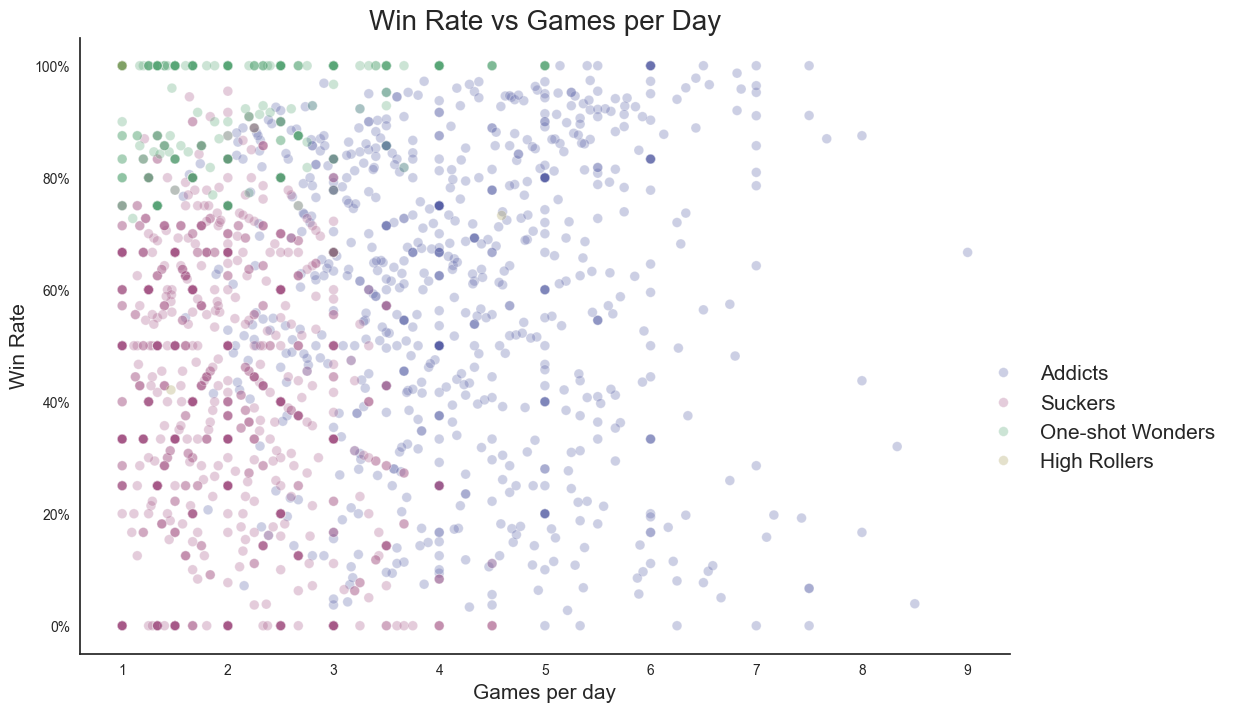

In [231]:
wr_gpd = plt.figure(figsize=(12, 8))
sns.scatterplot(data=res_df, x="Games_per_session", y="Win_rate", hue="Group", alpha=0.3, palette=shades)
# wr_gpd_grey = plt.figure(figsize=(12, 8))
# sns.scatterplot(data=res_df, x="Games_per_session", y="Win_rate", hue="Group", palette=["#aaaaaa"]*4)

sns.despine()
plt.xlabel("Games per day", fontsize=15)
plt.ylabel("Win Rate", fontsize=15)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(fontsize=15, bbox_to_anchor=(0.95, 0.5))
plt.title("Win Rate vs Games per Day", fontsize=20)
plt.show()

In [232]:
wr_gpd.savefig("Charts\\wr_gpd.png", transparent=True, bbox_inches="tight")
wr_gpd_grey.savefig("Charts\\wr_gpd_grey.png", transparent=True, bbox_inches="tight")

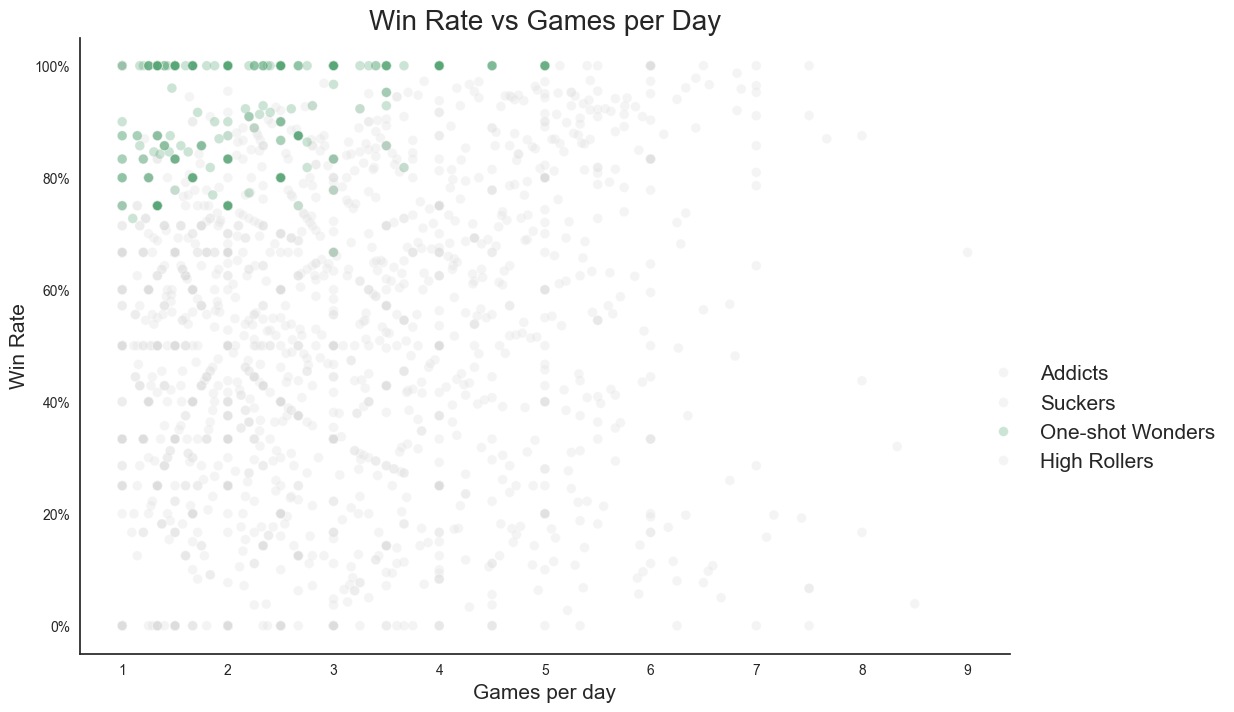

In [235]:
# adds = plt.figure(figsize=(12, 8))
# pal = [shades[0]] + ["#cccccc"]*3

# suckers = plt.figure(figsize=(12, 8))
# pal = ["#cccccc"] + [shades[1]] + ["#cccccc"]*2

osw = plt.figure(figsize=(12, 8))
pal = ["#dddddd"]*2 + [shades[2]] + ["#dddddd"]

sns.scatterplot(data=res_df, x="Games_per_session", y="Win_rate", hue="Group", alpha=0.3, palette=pal)
sns.despine()
plt.xlabel("Games per day", fontsize=15)
plt.ylabel("Win Rate", fontsize=15)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(fontsize=15, bbox_to_anchor=(0.95, 0.5))
plt.title("Win Rate vs Games per Day", fontsize=20)
plt.show()

In [236]:
adds.savefig("Charts\\addicts.png", transparent=True, bbox_inches="tight")
osw.savefig("Charts\\osw.png", transparent=True, bbox_inches="tight")
suckers.savefig("Charts\\suckers.png", transparent=True, bbox_inches="tight")

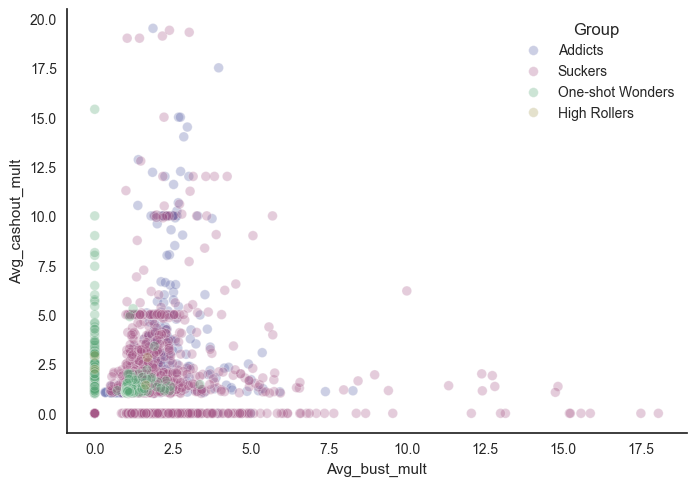

In [167]:
cond1 = res_df["Avg_bust_mult"] < 20
cond2 = res_df["Avg_cashout_mult"] < 20

sns.scatterplot(data=res_df.loc[cond1 & cond2],
                x="Avg_bust_mult", y="Avg_cashout_mult", hue="Group", alpha=0.3, palette=shades)
sns.despine()

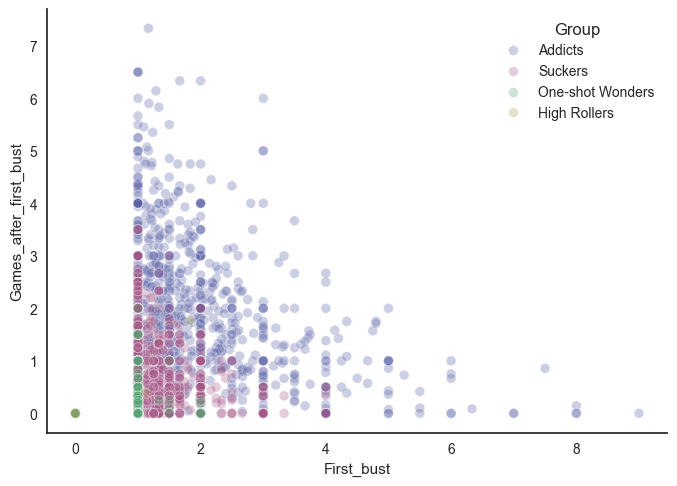

In [168]:
sns.scatterplot(data=res_df, x="First_bust", y="Games_after_first_bust", hue="Group", alpha=0.3, palette=shades)
sns.despine()

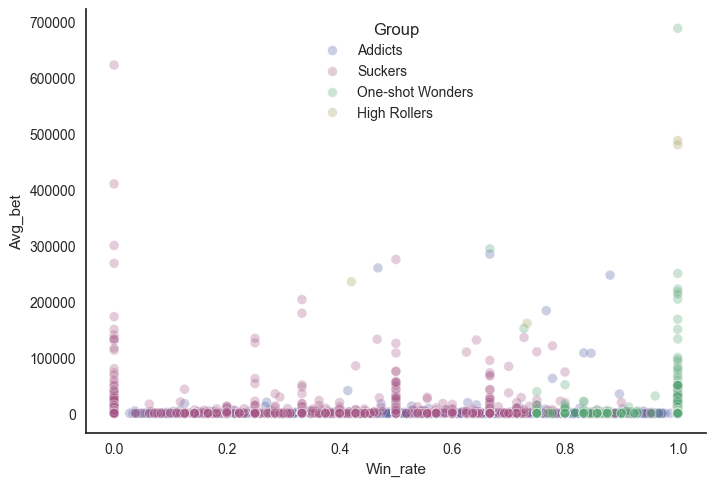

In [169]:
sns.scatterplot(data=res_df, x="Win_rate", y="Avg_bet", hue="Group", alpha=0.3, palette=shades)
sns.despine()

In [74]:
# def seconds_to_time(seconds):
#     hour = int(seconds // 3600)
#     seconds %= 3600
#     minute = int(seconds // 60)
#     second = int(seconds % 60)
#     return dt.time(hour, minute, second)

# res_df["Avg_time"] = res_df["Avg_time"].apply(seconds_to_time)

#### High Rollers

In [298]:
user_df["Cluster"] = pipe['kmeans'].labels_
high_rollers = user_df.loc[user_df["Cluster"]==3]
high_rollers

,Username,Num_games,Num_sessions,Total_amt_bet,Gross_profit,Net_profit,Num_wins,Num_busts,Win_rate,Games_per_session,...,First_bust,Games_after_first_bust,Busts_per_session,Avg_bet,Avg_cashout_mult,Avg_bust_mult,Avg_profit,Avg_PnL,Avg_time,Cluster
643,GPL89,2,2,975000,1875559.41,1875559.41,2,0,1.000000,1.000000,...,NaN,0.000000,0.000000,487500.000000,2.920000,NaN,937779.705000,937779.705000,63942.000000,3
2004,allg1124,101,22,16262350,4794154.34,3182621.34,74,27,0.732673,4.590909,...,1.833333,1.772727,1.227273,161013.366337,1.427297,1.636296,64785.869459,31511.102376,41102.801980,3
2667,goosin2000,19,13,4469000,3803213.87,1544213.87,8,11,0.421053,1.461538,...,1.111111,0.384615,0.846154,235210.526316,2.831250,1.690909,475401.733750,81274.414211,27628.210526,3
3584,sce919,1,1,480000,596856.84,596856.84,1,0,1.000000,1.000000,...,NaN,0.000000,0.000000,480000.000000,2.230000,NaN,596856.840000,596856.840000,3800.000000,3


In [305]:
print("High Rollers\n")

print(f'Number of players: {len(high_rollers)}')
print(f'Total games: {high_rollers["Num_games"].sum()}')
print(f'Total bits bet: {high_rollers["Total_amt_bet"].sum():,}')
print(f'Win Rate: {high_rollers["Num_wins"].sum() / high_rollers["Num_games"].sum():.6f}')
print(f'Net profit: {high_rollers["Net_profit"].sum():,}')

High Rollers

Number of players: 4
Total games: 123
Total bits bet: 22,186,350
Win Rate: 0.691057
Net profit: 7,199,251.46


In [308]:
print(f'2016 price: {high_rollers["Total_amt_bet"].sum() / 1000000 * 750:,}')
print(f"Today's price: {high_rollers['Total_amt_bet'].sum() / 1000000 * 70000:,}")

2016 price: 16,639.7625
Today's price: 1,553,044.5


## Observations

Play data from 31st Oct 2016 - 10th Dec 2016
During the period, BTC went from $700 to $775 (70000c)

Proportion in each cluster

- Cluster 0 => Adrenaline Junkies / Addicts
    - play a lot - most sessions on avg, most games per session on avg
    - they reload - highest avg number of games after the first bust
        - despite the fact their first bust comes later on avg
    - GAMES AFTER FIRST BUST

- Cluster 1 => Suckers / Joe Bloggs
    - "if you can't spot the sucker at the table, it's Cluster 2"
    - lowest win rate
    - avgcashout is low, so when they win they don't win big
    - avgbustmult is high, suggests a high risk tolerance that isn't feeding through into their cashouts...
    
- Cluster 2 => One-shot wonders
    - 
    - avg_bust_mult extremely low (due to fillna=0 for those who didn't lose)
    - 


- Cluster 3 => High-Rollers
    - Tiny group (4 users), so error bars are high
    - One played once, one played twice, one played 19 times and one played 101 times
    - Two distinguishing features:
        - they bet big (350k bits = $260, or $26,000 today)
        - they actually made money

Data caveats:

- assuming unique individuals behind Username
    - zzanggubank's net profit of 142k looks less impressive accounting for zzangu's loss of 84k...
- Out of 4149 players, 1231 never lost and 745 never won.
    - implications for some metrics

## Presentation

1. Title
- how the game works
    - choose how much you want to stake (bits, 1 millionth of a bitcoin)
    - watch the multiplier go up
    - at any point you can cash out, and 
    - to maintain the house edge, in 1/100 games everyone will bust
- what data do we have?
    - time period
    - individual user's outcome in a particular game
    - just over 4k unique users, across 42k unique games
- interesting to see if there are any patterns that reveal what type of player you are
    - do you have a high risk tolerance, midas touch, a tendency to rage quit
    
2. Clusters
- countplot + symbols overlay
- Games_per_session vs Win_rate

3. Addicts
- Num_games
- Games_after_first_bust + First_bust

4. Suckers
- Win_rate
- Avg_bust_mult
- (luckily they don't play that much)

5. One-shot wonders
- Num_games
- Win_rate
- Avg_bust_mult (hline for 1x)
- Games_after_first_bust ?

6. High-rollers
- Avg_bet
- List stats of the 4 individuals

7. Challenges & Caveats
- no features in the data - trying to create features that might be interesting, without overloading KMeans
- handling users who never lost or never won
- users - might not be distinct (zzanggu example)
- Only 1.5 months in 2016 - would be fascinating to know how it compares now given BTC price

## Final charts

In [248]:
res_df.columns

Index(['Num_games', 'Num_sessions', 'Total_amt_bet', 'Gross_profit',
       'Net_profit', 'Win_rate', 'Games_per_session', 'Wins_per_session',
       'First_bust', 'Games_after_first_bust', 'Avg_bet', 'Avg_cashout_mult',
       'Avg_bust_mult', 'Avg_profit', 'Avg_PnL', 'Avg_time', 'Cluster',
       'Group'],
      dtype='object')

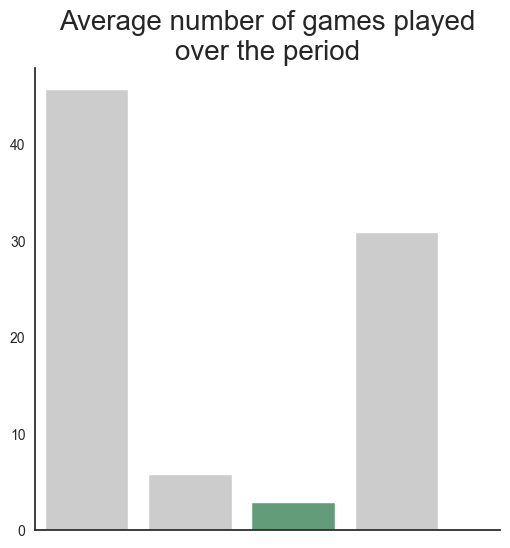

In [295]:
# Num_games

# num_games = plt.figure(figsize=(12, 6))
# num_games_addicts = plt.figure(figsize=(14, 6))
num_games_osw = plt.figure(figsize=(6, 6))

# sns.barplot(data=res_df, x="Group", y="Num_games", hue="Group", errorbar=None, palette=shades)
# sns.barplot(data=res_df, x="Group", y="Num_games", hue="Group", errorbar=None, palette=[shades[0]] + ["#cccccc"]*3)
sns.barplot(data=res_df, x="Group", y="Num_games", hue="Group", errorbar=None,
            palette=["#cccccc"]*2 + [shades[2]] + ["#cccccc"])

sns.despine()
# plt.xticks(fontsize=15)
plt.xticks("")
plt.xlabel("")
plt.ylabel("")
plt.title("Average number of games played\nover the period", fontsize=20)
plt.show()

# num_games.savefig("Charts\\num_games.png", transparent=True, bbox_inches="tight")
# num_games_addicts.savefig("Charts\\num_games_addicts.png", transparent=True, bbox_inches="tight")
num_games_osw.savefig("Charts\\num_games_osw.png", transparent=True, bbox_inches="tight")

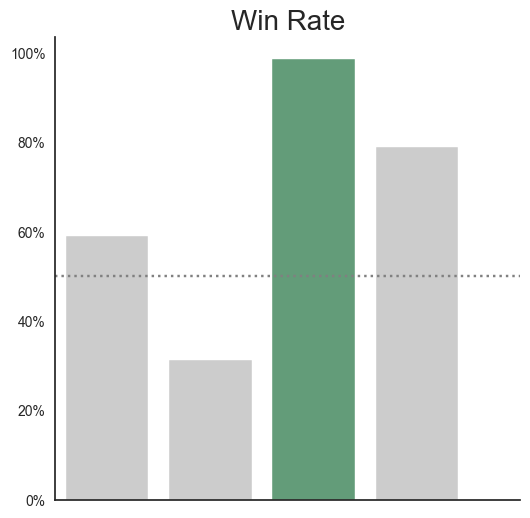

In [296]:
# Win_rate

# win_rate = plt.figure(figsize=(14, 6))
win_rate_osw = plt.figure(figsize=(6, 6))

# sns.barplot(data=res_df, x="Group", y="Win_rate", hue="Group", errorbar=None, palette=shades)
sns.barplot(data=res_df, x="Group", y="Win_rate", hue="Group", errorbar=None, 
            palette=["#cccccc"]*2 + [shades[2]] + ["#cccccc"])
plt.axhline(y=0.5, color="gray", linestyle=':')

sns.despine()
# plt.xticks(fontsize=15)
plt.xticks("")
plt.xlabel("")
plt.ylabel("")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Win Rate", fontsize=20)
plt.show()

# win_rate.savefig("Charts\\win_rate.png", transparent=True, bbox_inches="tight")
win_rate_osw.savefig("Charts\\win_rate_osw.png", transparent=True, bbox_inches="tight")

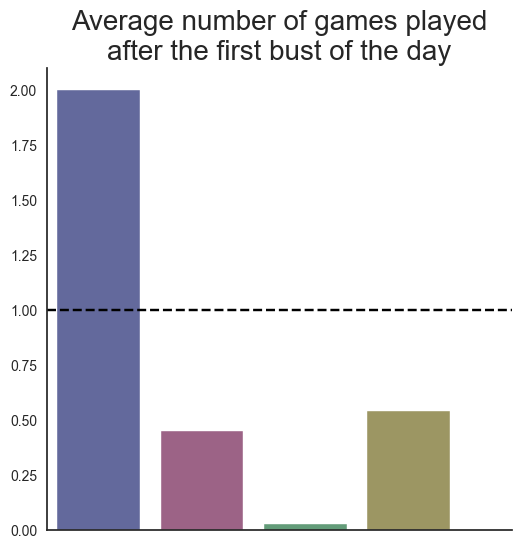

In [285]:
# Games_after_first_bust

# gafb = plt.figure(figsize=(12, 6))
gafb_addicts = plt.figure(figsize=(6, 6))

sns.barplot(data=res_df, x="Group", y="Games_after_first_bust", hue="Group", errorbar=None, palette=shades)
# sns.barplot(data=res_df, x="Group", y="Games_after_first_bust", hue="Group", 
#             errorbar=None, palette=[shades[0]] + ["#cccccc"]*3)

plt.axhline(y=1, color="black", linestyle='--')

sns.despine()
# plt.xticks(fontsize=15)
plt.xticks("")
plt.xlabel("")
plt.ylabel("")
plt.title("Average number of games played\nafter the first bust of the day", fontsize=20)
plt.show()

# gafb.savefig("Charts\\gafb.png", transparent=True, bbox_inches="tight")
gafb_addicts.savefig("Charts\\gafb_addicts.png", transparent=True, bbox_inches="tight")

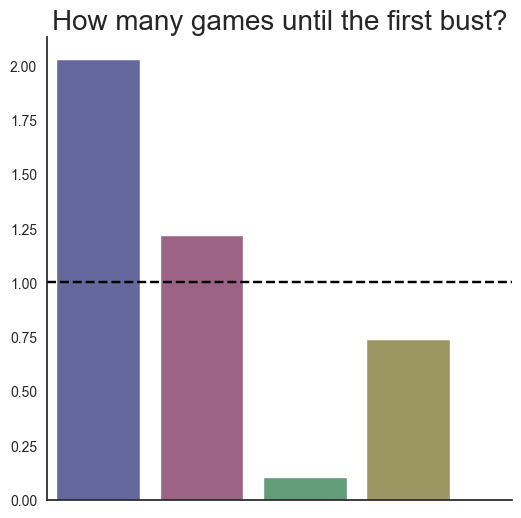

In [288]:
# First_bust

# first_bust = plt.figure(figsize=(12, 6))
first_bust_addicts = plt.figure(figsize=(6, 6))

sns.barplot(data=res_df, x="Group", y="First_bust", hue="Group", errorbar=None, palette=shades)
plt.axhline(y=1, color="black", linestyle='--')

sns.despine()
# plt.xticks(fontsize=15)
plt.xticks("")
plt.xlabel("")
plt.ylabel("")
plt.title("How many games until the first bust?", fontsize=20)
plt.show()

# first_bust.savefig("Charts\\first_bust.png", transparent=True, bbox_inches="tight")
first_bust_addicts.savefig("Charts\\first_bust_addicts.png", transparent=True, bbox_inches="tight")

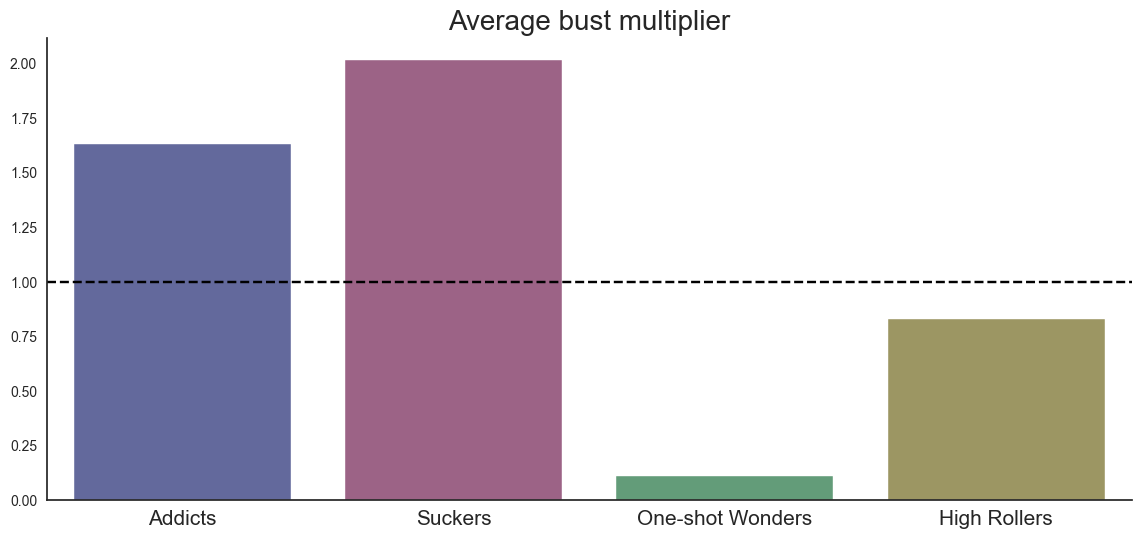

In [292]:
# Avg_bust_mult

# bust_mult = plt.figure(figsize=(14, 6))
bust_mult_osw = plt.figure(figsize=(6, 6))

# sns.barplot(data=res_df, x="Group", y="Avg_bust_mult", hue="Group", errorbar=None, palette=shades)
sns.barplot(data=res_df, x="Group", y="Avg_bust_mult", hue="Group", errorbar=None,
            palette=["#cccccc"]*2 + [shades[2]] + ["#cccccc"])
plt.axhline(y=1, color="black", linestyle='--')

sns.despine()
# plt.xticks(fontsize=15)
plt.xticks("")
plt.xlabel("")
plt.ylabel("")
plt.title("Average bust multiplier", fontsize=20)
plt.show()

# bust_mult.savefig("Charts\\bust_mult.png", transparent=True, bbox_inches="tight")
bust_mult_osw.savefig("Charts\\bust_mult_osw.png", transparent=True, bbox_inches="tight")

In [270]:
def comma_sep(x, pos):
    return f'{int(x):,}'

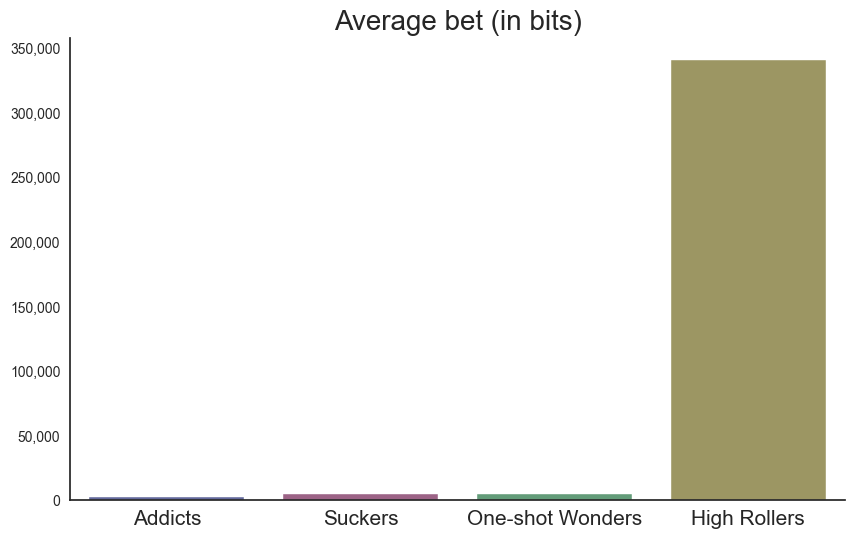

In [297]:
# Avg_bet

avg_bet = plt.figure(figsize=(10, 6))

sns.barplot(data=res_df, x="Group", y="Avg_bet", hue="Group", errorbar=None, palette=shades)

sns.despine()
plt.xticks(fontsize=15)
plt.xlabel("")
plt.ylabel("")
plt.title("Average bet (in bits)", fontsize=20)
plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_sep))
plt.show()
avg_bet.savefig("Charts\\avg_bet.png", transparent=True, bbox_inches="tight")

---------------------------------------------------------------

## DBScan

In [75]:
from sklearn.cluster import DBSCAN

In [76]:
scaler = StandardScaler()
cluster = DBSCAN()
pipe = make_pipeline(scaler, cluster)

pipe.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()), ('dbscan', DBSCAN())])

In [77]:
pd.Series(pipe['dbscan'].labels_).unique()

array([-1,  0,  1,  2,  3, 14, 11,  4,  5,  6,  7,  8,  9, 10, 13, 16, 12,
       15, 17, 20, 19, 21, 18], dtype=int64)

In [78]:
res_df["DBCluster"] = pipe['dbscan'].labels_

<Axes: xlabel='DBCluster', ylabel='count'>

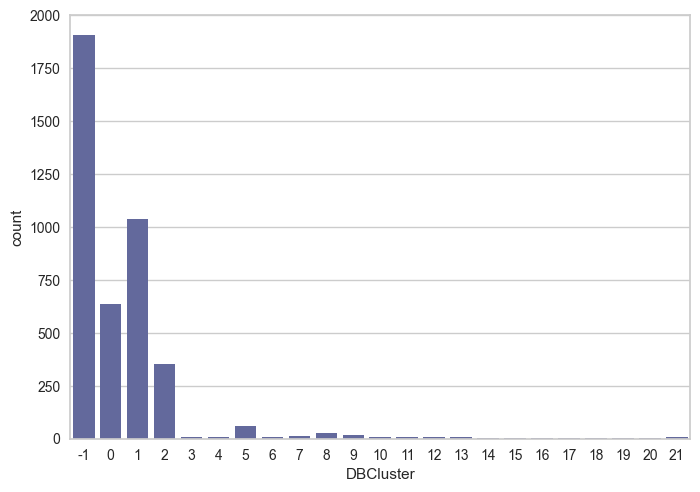

In [79]:
sns.countplot(data=res_df, x="DBCluster")

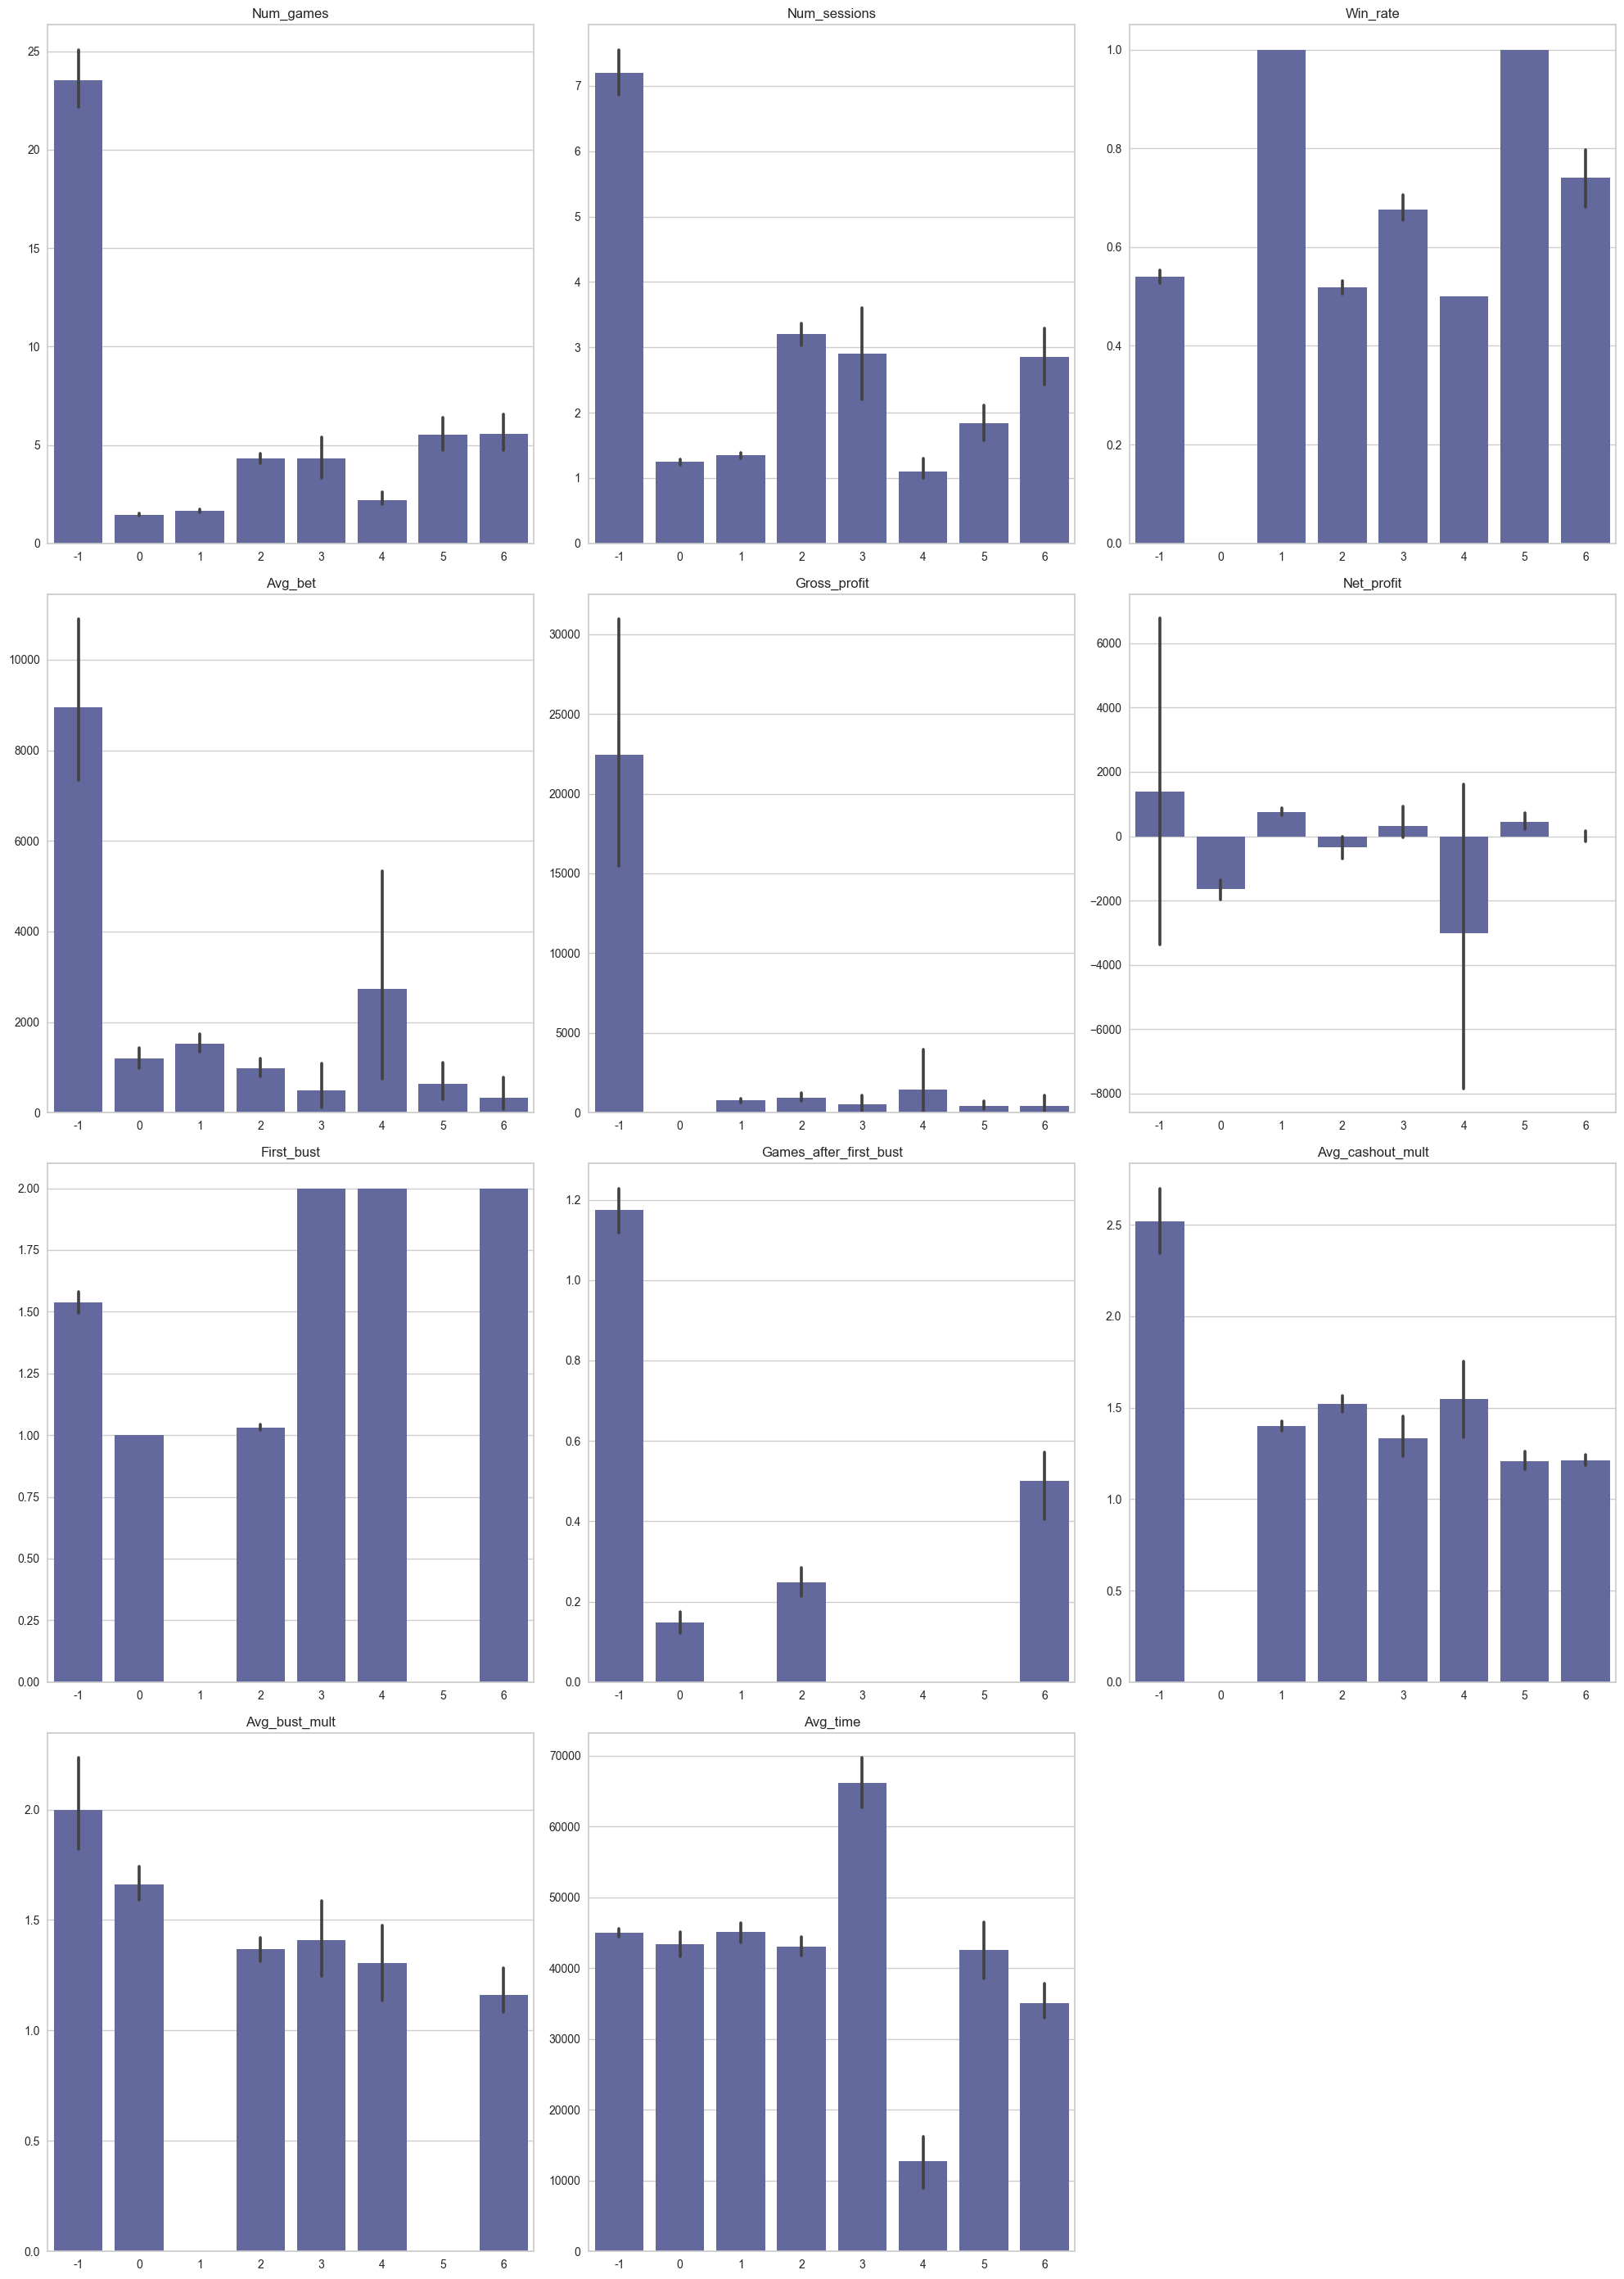

In [80]:
var_lst = '''
    Num_games
    Num_sessions
    Win_rate
    Avg_bet
    Gross_profit
    Net_profit
    First_bust
    Games_after_first_bust
    Avg_cashout_mult
    Avg_bust_mult
    Avg_time
'''.split()

fig_rows = math.ceil(len(var_lst)/3)

fig, axs = plt.subplots(fig_rows, 3, figsize=(20, 7*fig_rows))

for var, ax in zip(var_lst, axs.flat):
    g = sns.barplot(data=res_df.loc[res_df["DBCluster"]<7], x="DBCluster", y=var, ax=ax)
    # Formatting
    ax.set(xlabel='', ylabel='', title=var)
    
# Remove spare plot
for i in axs.flat[::-1][:fig_rows*3 - len(var_lst)]:
    i.set_axis_off()
    
plt.tight_layout()
plt.show()